In [2]:
import pandas as pd
from betfairlightweight import StreamListener
from betfairlightweight.streaming.stream import MarketStream
import betfairlightweight
import json
import utils
from utils_hist import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
# %load_ext nb_black

In [3]:
with open("api_logins.json") as f:
    login_dict = json.load(f)

trading = utils.trading_instance()

In [26]:
file = "1.169341990"
file_dir = f"../../../../betfair/betfair_project/data/raw/api/advanced/{file}"

In [27]:
datadict = {
    "Time": [],
    "MarketId": [],
    "Status": [],
    "Inplay": [],
    "SelectionId": [],
    "LastPriceTraded": [],
    "TotalMatched": [],
    "BSP": [],
    "AdjFactor": [],
    "RunnerStatus": [],
    "MktTotalMatched": [],
    "RaceInfo": [],
    "Venue": [],
}


class HistoricalStream(MarketStream):
    # create custom listener and stream

    def _init_(self, listener):
        super(HistoricalStream, self)._init_(listener)

    def on_process(self, market_books):
        for market_book in market_books:
            for runner in market_book.runners:

                datadict["Time"].append(market_book.publish_time)
                datadict["MarketId"].append(float(market_book.market_id))
                datadict["Status"].append(market_book.status)
                datadict["Inplay"].append(market_book.inplay)
                datadict["SelectionId"].append(runner.selection_id)
                datadict["LastPriceTraded"].append(runner.last_price_traded)
                datadict["TotalMatched"].append(runner.total_matched)
                datadict["BSP"].append(runner.sp.actual_sp)
                datadict["AdjFactor"].append(runner.adjustment_factor)
                datadict["RunnerStatus"].append(runner.status)
                datadict["MktTotalMatched"].append(market_book.total_matched)
                datadict["RaceInfo"].append(market_book.market_definition.name)
                datadict["Venue"].append(market_book.market_definition.venue)


class HistoricalListener(StreamListener):
    def _add_stream(self, unique_id, stream_type):
        if stream_type == "marketSubscription":
            return HistoricalStream(self)

In [28]:
listener = HistoricalListener(max_latency=None)

In [29]:
stream = trading.streaming.create_historical_stream(
    file_path=file_dir, listener=listener
)
stream.start()
stream.stop()

df = pd.DataFrame(datadict)

# extract time -> seconds
df["time_sec"] = df["Time"].dt.round("1s")

# remove duplicates (by second)
df = df.drop_duplicates(["SelectionId", "time_sec"], "last")

# keep races only before off
df = df.loc[(df["Inplay"] == False) & (df["Status"] == "OPEN")].copy()

# remove non-runners
nrs = df.loc[df['RunnerStatus'] == 'REMOVED']['SelectionId'].unique()
df = df.loc[~df['SelectionId'].isin(nrs)].copy()

# remove outsiders (100/1 +)
outs = df.loc[df['LastPriceTraded'] > 100]['SelectionId'].unique()
df = df.loc[~df['SelectionId'].isin(outs)].copy()

INFO:betfairlightweight.streaming.listener:Register: marketSubscription 0
INFO:betfairlightweight.streaming.stream:[Stream: 0]: "HistoricalStream" created
INFO:betfairlightweight.streaming.stream:[MarketStream: 0] 1.169341990 added, 1 markets in cache


<Figure size 1008x432 with 0 Axes>

AxesSubplot(0.125,0.125;0.775x0.755)


<Figure size 1008x432 with 0 Axes>

AxesSubplot(0.125,0.125;0.775x0.755)


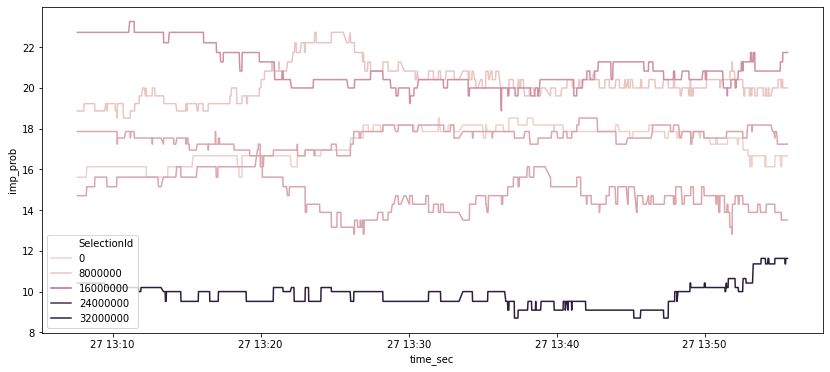

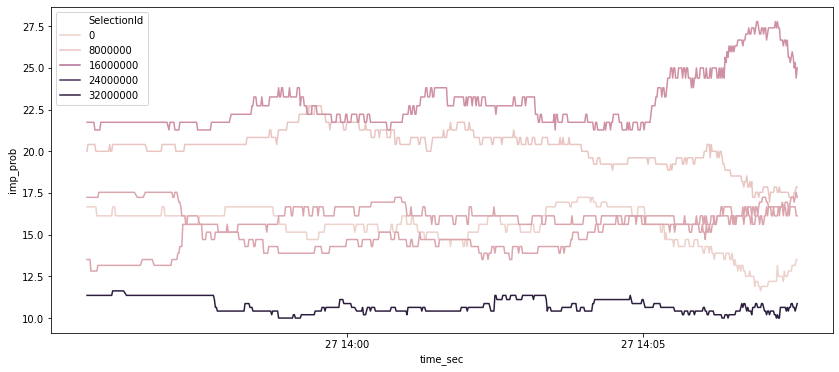

In [30]:
# keep data X data points before off
period_mins = 60 # X minutes before off
watch_pct = 0.8 # X% of period used to train/watch

period_max = df.sort_values("Time")["Time"].tail(1).values[0].copy()
period_min = period_max - np.timedelta64(period_mins, "m")

watch_end = period_max - np.timedelta64(round(period_mins * (1 - watch_pct)), "m")

df = df.loc[(df["time_sec"] > period_min) & (df["time_sec"] < period_max)].copy()

# find imp-prob
df = df.loc[df["LastPriceTraded"] != 0].copy()
df["imp_prob"] = df["LastPriceTraded"].apply(lambda x: round(1 / x, 4) * 100)

# drop unnecessary columns
df = df[["time_sec", "SelectionId", "LastPriceTraded", "imp_prob"]].copy()

#     df.head()
#     print(str() + " stream completed.")

plt.figure(figsize=(14, 6))
print(sns.lineplot(x="time_sec", y="imp_prob", hue="SelectionId",
                   data=df.loc[df['time_sec'] < watch_end]))

plt.figure(figsize=(14, 6))
print(sns.lineplot(x="time_sec", y="imp_prob", hue="SelectionId",
                   data=df.loc[df['time_sec'] > watch_end]))

In [31]:
ip_series = df.pivot(index="time_sec", columns="SelectionId")["imp_prob"]
ip_series_watch = ip_series.loc[ip_series.index < watch_end].copy()
ip_series_react = ip_series.loc[ip_series.index > watch_end].copy()

In [32]:
df['time_sec'].nunique()

2343

In [33]:
ip_series.shape

(2343, 6)

In [34]:
ip_series.index.nunique()

2343

In [395]:
# df.loc[df['SelectionId'] == 24456069] # this is giving nan as a result - why? does it matter?

In [396]:
cor_mat = ip_series_watch.corr()
cor_mat

SelectionId,6820161,7835147,10680680,10685365,12496744,26228213
SelectionId,,,,,,
6820161,1.000000,0.304289,0.780467,-0.599896,-0.727699,-0.497437
7835147,0.304289,1.000000,0.398720,-0.696538,-0.651223,-0.100654
10680680,0.780467,0.398720,1.000000,-0.835430,-0.788167,-0.115265
10685365,-0.599896,-0.696538,-0.835430,1.000000,0.753828,-0.068912
12496744,-0.727699,-0.651223,-0.788167,0.753828,1.000000,0.206006
26228213,-0.497437,-0.100654,-0.115265,-0.068912,0.206006,1.000000


In [397]:
def getIndexes(dfObj, value):
    """ Get index positions of value in dataframe i.e. dfObj."""
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.le(value)
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row, col))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [398]:
pairs = getIndexes(cor_mat, -0.6) # is this efficient? ideal would be to remove duplicates from matrix
pairs = list(set([ tuple(sorted(t)) for t in pairs]))
pairs

[(7835147, 12496744),
 (10680680, 10685365),
 (6820161, 12496744),
 (10680680, 12496744),
 (7835147, 10685365)]

In [399]:
def plot_pairs(p):
    print(p)
    plot_df = df.loc[(df['SelectionId'].isin(p)) & (df['time_sec'] < watch_end)]
    
    plt.figure(figsize=(14,6))
    sns.lineplot(x="time_sec", y="imp_prob", hue="SelectionId",
                   data=plot_df, palette=sns.color_palette("Set1", plot_df['SelectionId'].nunique()))
    plt.show()
    
    plot_df = df.loc[(df['SelectionId'].isin(p)) & (df['time_sec'] > watch_end)]
    
    plt.figure(figsize=(14,6))
    sns.lineplot(x="time_sec", y="imp_prob", hue="SelectionId",
                   data=plot_df, palette=sns.color_palette("Set1", plot_df['SelectionId'].nunique()))
    plt.show()



 Next pair 


(7835147, 12496744)


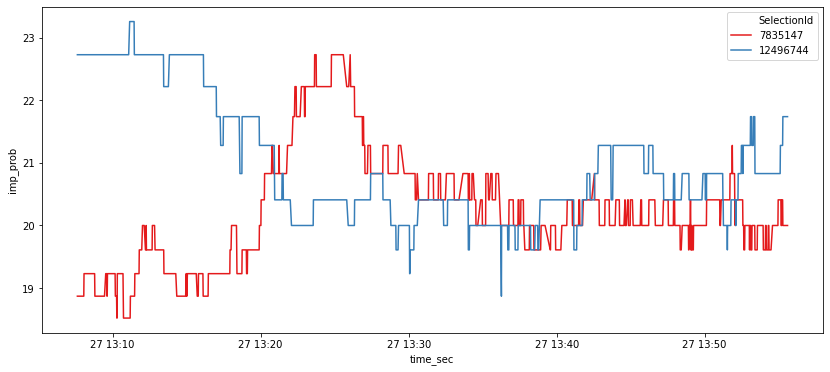

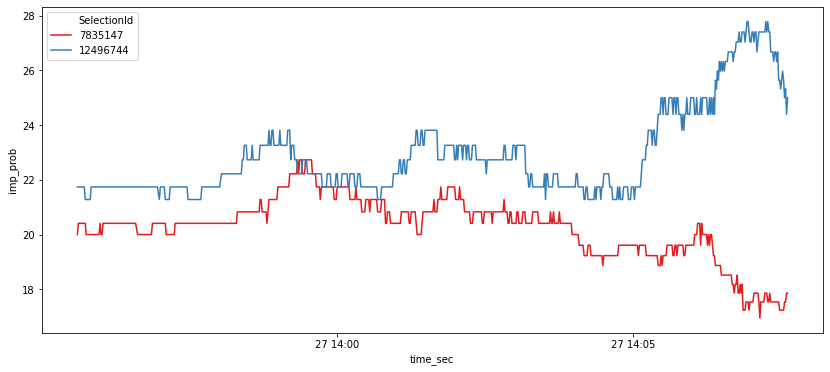

In [409]:
for pair in pairs[0:1]:
    print('\n\n Next pair \n\n')
    plot_pairs(pair)

---

In [459]:
test = ip_series_react[['7835147', '12496744']].copy()

In [460]:
test.columns  = test.columns.astype(str)

In [461]:
# find differences between time points
p1 = '7835147'
p2 = '12496744'

test[f'{p1}_dif'] = test[p1].diff().copy()
test[f'{p2}_dif'] = test[p2].diff().copy()

In [462]:
test
test.shape

SelectionId,7835147,12496744,7835147_dif,12496744_dif
time_sec,,,,
2020-02-27 13:55:37,20.00,21.74,NaN,NaN
2020-02-27 13:55:38,20.41,21.74,0.41,0.00
2020-02-27 13:55:39,20.41,21.74,0.00,0.00
2020-02-27 13:55:40,20.41,21.74,0.00,0.00
2020-02-27 13:55:41,20.41,21.74,0.00,0.00
...,...,...,...,...
2020-02-27 14:07:32,17.24,25.64,0.00,-0.33
2020-02-27 14:07:33,17.54,25.00,0.30,-0.64
2020-02-27 14:07:34,17.54,25.32,0.00,0.32


(698, 4)

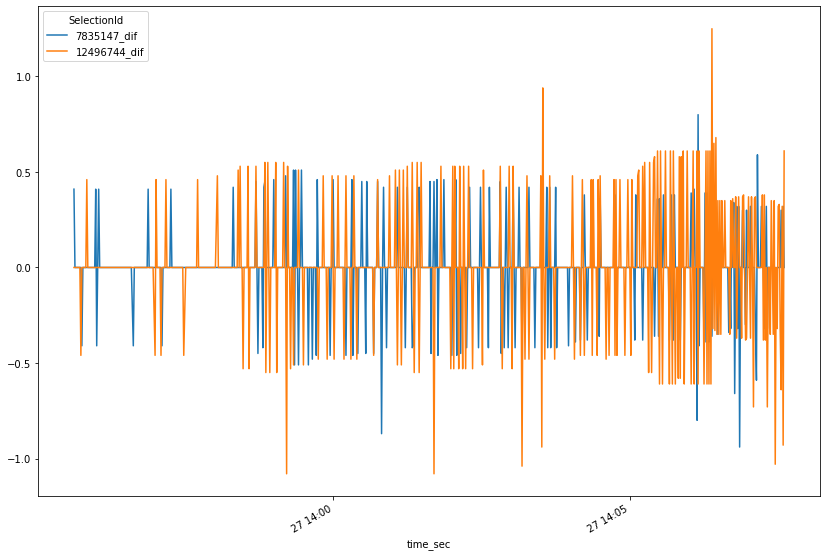

In [463]:
test[['7835147_dif', '12496744_dif']].plot(figsize=(14,10))

In [469]:
def plot_price_change(sid):
    sns.distplot(test[f'{sid}_dif'])
    sns.distplot(test.loc[test[f'{sid}_dif'].gt(0)][f'{sid}_dif'])
    print('Mean positive changes : ', round(test.loc[test[f'{sid}_dif'] > 0][f'{sid}_dif'].mean(), 2))
    sns.distplot(test.loc[test[f'{sid}_dif'].lt(0)][f'{sid}_dif'])
    print('Mean negative changes : ', round(test.loc[test[f'{sid}_dif'] < 0][f'{sid}_dif'].mean(), 2))

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


Mean positive changes :  0.41
Mean negative changes :  -0.43


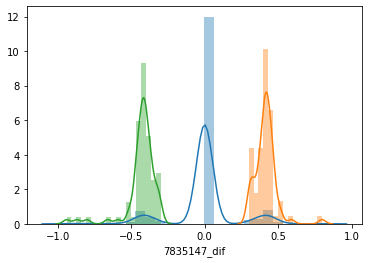

In [470]:
plot_price_change('7835147')

/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in greater
  x = x[np.logical_and(x > clip[0], x < clip[1])]
/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:547: RuntimeWarning: invalid value encountered in less
  x = x[np.logical_and(x > clip[0], x < clip[1])]


Mean positive changes :  0.5
Mean negative changes :  -0.53


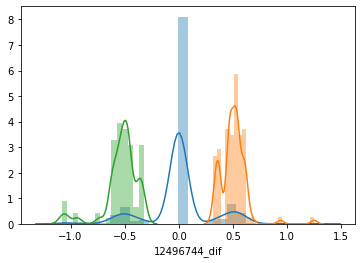

In [471]:
plot_price_change('12496744')

In [ ]:
^ this will inform the arbitrary change e.g take if inc, is it more than mean positive increase?

In [ ]:
---

In [ ]:
### if wanting to use granger causality in future

# from  itertools import combinations
# possible_pairs = list(combinations(ip_series.columns, 2))

# for k,v in possible_pairs:
#     for lag in [1, 5, 10, 30, 60, 90]:
#         print(grangercausalitytests(ip_series[[k, v]], [lag])['ssr_ftest'][1])
#         print(grangercausalitytests(ip_series[[v, k]], [lag])['ssr_ftest'][1])